<a href="https://colab.research.google.com/github/ChoiDae1/StyleCLIP-PyTorch/blob/main/Implementing_StyleCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Style CLIP 구현**

"StyleCLIP: Text-Driven Manipulation of StyleGAN Imagery" 논문에서 제시한 **Style CLIP** 구현

논문에서 Style CLIP은 크게 **세가지 방법**으로 구현할 수 있는데, 다음과 같다.

- Latent Optimization 
- Latent Mapper
- Global Direction

여기서는 가장 간단한 방법은 **Latent Optimization**을 통해 구현

### **Install CLIP**

In [2]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 53 kB 1.1 MB/s 
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-f6axt9pc
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-f6axt9pc
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369221 sha256=1610de331795fe9f3840f222c35aff14bfe9722c4e85240e4b9f8b9f11aab246
  Stored in directory: /tmp/pip-ephem-wheel-cache-97njpc8i/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


### **Load the Pre-trained StyleGAN Model**

In [3]:
!git clone https://github.com/ndb796/StyleCLIP-Tutorial
%cd StyleCLIP-Tutorial

Cloning into 'StyleCLIP-Tutorial'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 64 (delta 19), reused 10 (delta 0), pack-reused 0
Unpacking objects: 100% (64/64), done.
/content/StyleCLIP-Tutorial


In [4]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVv6yusEt1tFhrL3TCu0Ta4BlpzW3eBMTS0yTPKodNHsNA?download=1 -O stylegan2-ffhq-config-f.pt

--2022-02-23 16:23:04--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVv6yusEt1tFhrL3TCu0Ta4BlpzW3eBMTS0yTPKodNHsNA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 52.105.209.27
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|52.105.209.27|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/stylegan2-ffhq-config-f.pt [following]
--2022-02-23 16:23:05--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/stylegan2-ffhq-config-f.pt
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 381462551 (364M) [application/octet-stream]
Saving to: ‘stylegan2-ffhq-config-f.pt’

stylegan2-ffhq-conf 100%[===================>] 363.79M  15.5MB/s    in 28s     

2022-02-23 16:23:34 (13.2 MB/s) - ‘stylegan2-ff

In [5]:
import torch
from stylegan2.model import Generator


g_ema = Generator(1024, 512, 8)
g_ema.load_state_dict(torch.load('stylegan2-ffhq-config-f.pt')["g_ema"], strict=False)
g_ema.eval()
g_ema.cuda()

Generator(
  (style): Sequential(
    (0): PixelNorm()
    (1): EqualLinear(512, 512)
    (2): EqualLinear(512, 512)
    (3): EqualLinear(512, 512)
    (4): EqualLinear(512, 512)
    (5): EqualLinear(512, 512)
    (6): EqualLinear(512, 512)
    (7): EqualLinear(512, 512)
    (8): EqualLinear(512, 512)
  )
  (input): ConstantInput()
  (conv1): StyledConv(
    (conv): ModulatedConv2d(512, 512, 3, upsample=False, downsample=False)
    (noise): NoiseInjection()
    (activate): FusedLeakyReLU()
  )
  (to_rgb1): ToRGB(
    (conv): ModulatedConv2d(512, 3, 1, upsample=False, downsample=False)
  )
  (convs): ModuleList(
    (0): StyledConv(
      (conv): ModulatedConv2d(512, 512, 3, upsample=True, downsample=False)
      (noise): NoiseInjection()
      (activate): FusedLeakyReLU()
    )
    (1): StyledConv(
      (conv): ModulatedConv2d(512, 512, 3, upsample=False, downsample=False)
      (noise): NoiseInjection()
      (activate): FusedLeakyReLU()
    )
    (2): StyledConv(
      (conv): Modul

### **CLIP Loss**

In [29]:
import clip
import torch.nn as nn

class CLIPLoss(nn.Module):
    def __init__(self):
        super(CLIPLoss, self).__init__()
        self.model, self.preprocess = clip.load("ViT-B/32")
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=32)
    
    def forward(self, image, text):
        image = self.avg_pool(self.upsample(image)) # (1, 3, 224, 224)
        similarity = 1 - self.model(image, text)[0] / 100
        return  similarity

### **Latent Optimization**

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


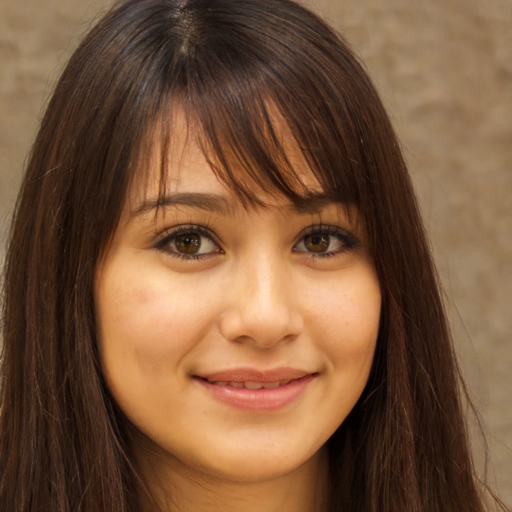

In [22]:
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

mean_latent = g_ema.mean_latent(4096)

latent_code_init_not_trunc = torch.randn(1, 512).cuda()
with torch.no_grad():
    img_orig, latent_code_init = g_ema([latent_code_init_not_trunc], return_latents=True,
                                truncation=0.7, truncation_latent=mean_latent)

# Visualize a random latent vector.
image = ToPILImage()(make_grid(img_orig.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = image.size
image.resize((h // 2, w // 2))

In [23]:
print(img_orig.shape) # Style GAN이 만들어내는 이미지 shape
print(latent_code_init.shape)

torch.Size([1, 3, 1024, 1024])
torch.Size([1, 18, 512])


In [24]:
upsample = torch.nn.Upsample(scale_factor=7)
upsample_img = upsample(img_orig)
print(upsample_img.shape)

torch.Size([1, 3, 7168, 7168])


In [25]:
avgpool = torch.nn.AvgPool2d(kernel_size=32)
pooled_img = avgpool(upsample_img)
print(pooled_img.shape)

torch.Size([1, 3, 224, 224])


In [40]:
from argparse import Namespace


args = Namespace()
args.description = 'really sad face' 
args.lr_rampup = 0.05  
args.lr = 0.1          # learning rate
args.step = 150        # Updata step  
args.l2_lambda = 0.005 # The weight for similarity to the original image.
args.save_intermediate_image_every = 1
args.results_dir = 'results'

In [41]:
text_inputs = torch.cat([clip.tokenize(args.description)])
print(text_inputs)

tensor([[49406,  1414,  3719,  1710, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])


In [42]:
import os
import math
import torchvision
from torch import optim


# The learning rate adjustment function.
def get_lr(t, initial_lr, rampdown=0.50, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp


text_inputs = torch.cat([clip.tokenize(args.description)]).cuda() # clip에 들어가는 text 토큰화 -> text
os.makedirs(args.results_dir, exist_ok=True)

# Initialize the latent vector to be updated.
latent = latent_code_init.detach().clone()
latent.requires_grad = True

clip_loss = CLIPLoss()
optimizer = optim.Adam([latent], lr=args.lr)

for i in range(args.step):
    # Adjust the learning rate.
    t = i / args.step
    lr = get_lr(t, args.lr) # step 마다 learning rate update
    optimizer.param_groups[0]["lr"] = lr

    # Generate an image using the latent vector.
    img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)

    # Calculate the loss value.
    c_loss = clip_loss(img_gen, text_inputs)
    l2_loss = ((latent_code_init - latent) ** 2).sum()
    loss = c_loss + args.l2_lambda * l2_loss

    # Get gradient and update the latent vector.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log the current state.
    print(f"lr: {lr}, loss: {loss.item():.4f}")
    if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every == 0:
        with torch.no_grad():
            img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)
        torchvision.utils.save_image(img_gen, f"results/{str(i).zfill(5)}.png", normalize=True, range=(-1, 1))

with torch.no_grad():
    img_orig, _ = g_ema([latent_code_init], input_is_latent=True, randomize_noise=False)

# Display the initial image and result image.
final_result = torch.cat([img_orig, img_gen])
torchvision.utils.save_image(final_result.detach().cpu(), os.path.join(args.results_dir, "final_result.jpg"), normalize=True, scale_each=True, range=(-1, 1))

lr: 0.0, loss: 0.7832


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


lr: 0.013333333333333334, loss: 0.7832
lr: 0.02666666666666667, loss: 0.7793
lr: 0.04, loss: 0.7930
lr: 0.05333333333333334, loss: 0.7935
lr: 0.06666666666666667, loss: 0.7954
lr: 0.08, loss: 0.7920
lr: 0.09333333333333334, loss: 0.7925
lr: 0.1, loss: 0.7910
lr: 0.1, loss: 0.7876
lr: 0.1, loss: 0.7861
lr: 0.1, loss: 0.7822
lr: 0.1, loss: 0.7759
lr: 0.1, loss: 0.7788
lr: 0.1, loss: 0.7827
lr: 0.1, loss: 0.8003
lr: 0.1, loss: 0.7886
lr: 0.1, loss: 0.7910
lr: 0.1, loss: 0.7842
lr: 0.1, loss: 0.7910
lr: 0.1, loss: 0.7900
lr: 0.1, loss: 0.8125
lr: 0.1, loss: 0.8076
lr: 0.1, loss: 0.8047
lr: 0.1, loss: 0.8047
lr: 0.1, loss: 0.7939
lr: 0.1, loss: 0.7900
lr: 0.1, loss: 0.8003
lr: 0.1, loss: 0.7979
lr: 0.1, loss: 0.7983
lr: 0.1, loss: 0.7959
lr: 0.1, loss: 0.7964
lr: 0.1, loss: 0.7949
lr: 0.1, loss: 0.8105
lr: 0.1, loss: 0.7871
lr: 0.1, loss: 0.7861
lr: 0.1, loss: 0.7827
lr: 0.1, loss: 0.7793
lr: 0.1, loss: 0.7754
lr: 0.1, loss: 0.7710
lr: 0.1, loss: 0.7715
lr: 0.1, loss: 0.7710
lr: 0.1, loss: 

### **Result Visualization**

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


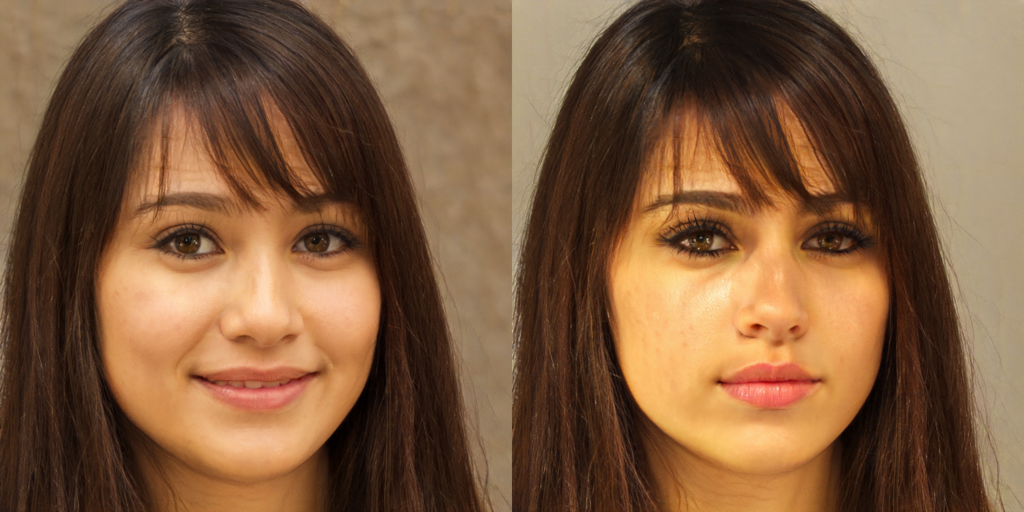

In [43]:
result_image = ToPILImage()(make_grid(final_result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))

In [44]:
!ffmpeg -r 15 -i results/%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4

from google.colab import files
files.download('out.mp4')

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>